# Imports #

In [1]:
import glob
import numpy as np
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt

In [2]:
import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

In [3]:
import tracking
import features
import training

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.dpi'] = 50
plt.rcParams['figure.figsize'] = (18,9)

# Training #

In [5]:
# Full dataset
vehicles = np.stack(cv2.imread(f) for f in glob.glob('vehicles/*/*'))
non_vehicles = np.stack(cv2.imread(f) for f in glob.glob('non-vehicles/*/*'))

# # Small dataset
# vehicles = np.stack(cv2.imread(f) for f in glob.glob('vehicles_smallset/*/*')[:])
# non_vehicles = np.stack(cv2.imread(f) for f in glob.glob('non-vehicles_smallset/*/*')[:])

In [6]:
X = np.concatenate([    vehicles, #    vehicles[:, :, ::-1, :],
                    non_vehicles, #non_vehicles[:, :, ::-1, :],
                  ])
Y = np.concatenate([np.ones(len(vehicles)*1), np.zeros(len(non_vehicles)*1)])

In [7]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

In [136]:
feature_extractor = features.FeatureExtraction(hog_channel="ALL", hog_cells_per_step=4, cspace='HLS')
classifier = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("svm", sklearn.svm.LinearSVC(C=1e3)),
], memory='./sklearn-cache')

pipeline = sklearn.pipeline.Pipeline([
    ("features", feature_extractor),
    ('classifier', classifier),
], memory='./sklearn-cache')

In [137]:
%time pipeline.fit(X_train, Y_train);
;

CPU times: user 16.2 s, sys: 5.43 s, total: 21.6 s
Wall time: 38.9 s


''

In [138]:
res = {}
t = %timeit -n1 -r1 -q -o res['pred'] = pipeline.predict(X_test)
pred = res['pred']
accuracy = sklearn.metrics.accuracy_score(Y_test, pred)

In [139]:
print("Prediction time: {:.1f} ms/sample".format(t.best*1000/len(X_test)))
print("Accuracy:        {:.1%}".format(accuracy))

Prediction time: 5.5 ms/sample
Accuracy:        98.6%


In [157]:
training.store_model('liblinear.P', None, pipeline, accuracy, {})
pipe2 = training.load_model('liblinear.P')[0]

In [158]:
res = {}
t = %timeit -n1 -r1 -q -o res['pred'] = pipe2.predict(X_test)
pred2 = res['pred']
accuracy2 = sklearn.metrics.accuracy_score(Y_test, pred2)

In [159]:
print("Prediction time: {:.1f} ms/sample".format(t.best*1000/len(X_test)))
print("Accuracy:        {:.1%}".format(accuracy2))

Prediction time: 4.7 ms/sample
Accuracy:        98.6%


# Tracking #

In [64]:
_, feature_extractor, classifier = training.load_model('./test.P')
#_, feature_extractor, classifier = training.load_model('./model_local_all_classifier-svm-C=1000.0_classifier-svm-kernel=linear_features-cspace=HLS_features-hog_channels=ALL.P')

In [147]:
idx = slice(1, 4, 4)
tracker = tracking.CarTracker(yranges=[(350, 680), (350, 680), (350, 680), (350, 680)][idx],
                              scales=[0.5, 1, 1.5, 2][idx],
                              colors=[(192,  32,  32), ( 32, 192,  32),
                                      ( 32,  32, 192), ( 64, 224, 192)][idx],
                              hog_cells_per_step=4,
                              heat_threshold=1,
                              extract_features=feature_extractor.extract_features,
                              predict=classifier.predict,
                              merge_boxes=True,
                              expand_maximum=False,
                              fir_length=10,
                              )

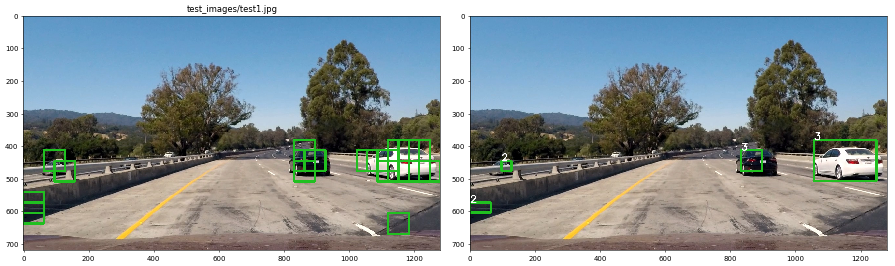

In [154]:
%%prun -s cumtime -l features|hist
for path in sorted(glob.glob('test_images/*'))[:1]:
    image = cv2.imread(path)[..., ::-1]
    tracker.last_boxes.clear()
    result, unmerged = tracker(image, return_unmerged=True)
    
    plt.subplot(121)
    plt.imshow(unmerged)
    plt.title(path)
    
    plt.subplot(122)
    plt.imshow(result)
    
    plt.tight_layout()
    plt.show()

In [135]:
from moviepy.editor import VideoFileClip
tracker.last_boxes.clear()
clip = VideoFileClip('project_video.mp4').subclip(6, 10)
output = clip.fl_image(tracker)
output.write_videofile('test.mp4', audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 99%|█████████▉| 100/101 [11:35<00:07,  7.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



<video controls src="test.mp4" width="100%"/>

In [129]:
import collections
d = collections.deque((), 5)
[d.appendleft(x) for x in range(10)]
d

deque([9, 8, 7, 6, 5])

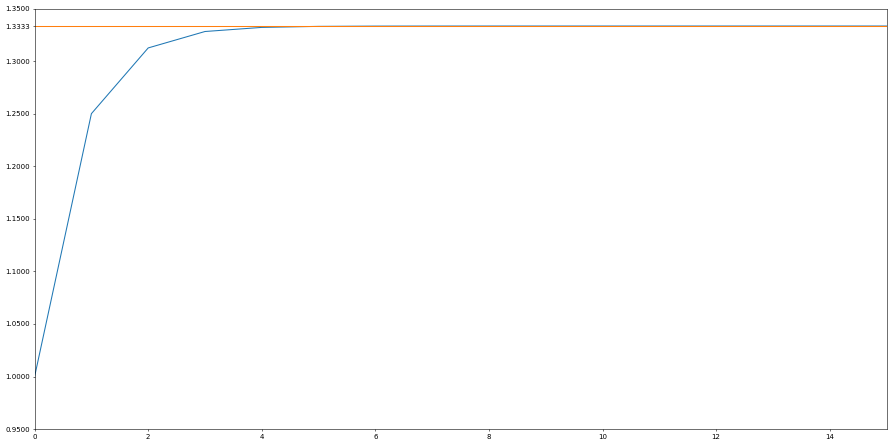

In [121]:
alpha = 0.25
h = 0
f = 1

x = np.linspace(0, 15, 16)
y = h * alpha ** x + f*(alpha**(x+1) - 1) / (alpha - 1)
l = f / (1 - alpha)
plt.plot(x, y)
plt.axhline(l, 0, 1, c='C1')
plt.yticks(plt.yticks()[0].tolist() + [l])
plt.xlim(x.min(), x.max())
plt.tight_layout()

alpha = 0.5

h = np.arange(1, 16)
l = np.log(1/h) / np.log(alpha)
plt.plot(h, l)
plt.xlim(l.min(), l.max())
plt.xlim(h.min(), h.max())
plt.tight_layout()

15.243462198


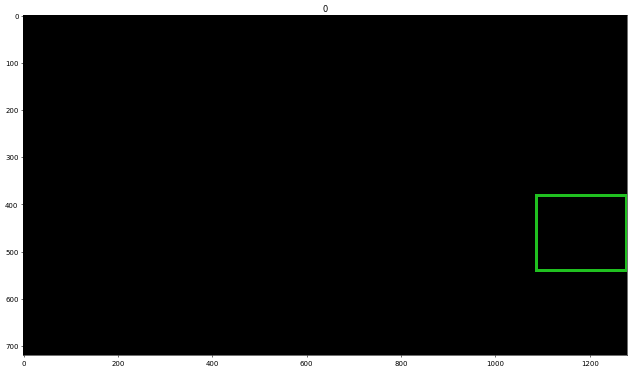

13.7191159782


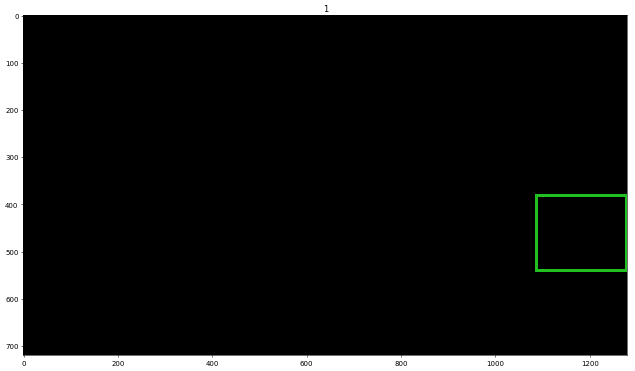

12.3472043804


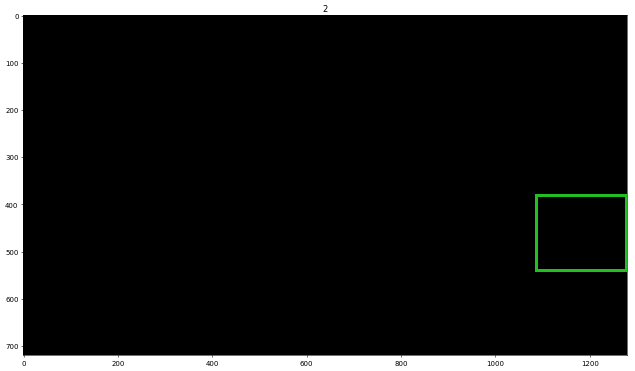

11.1124839423


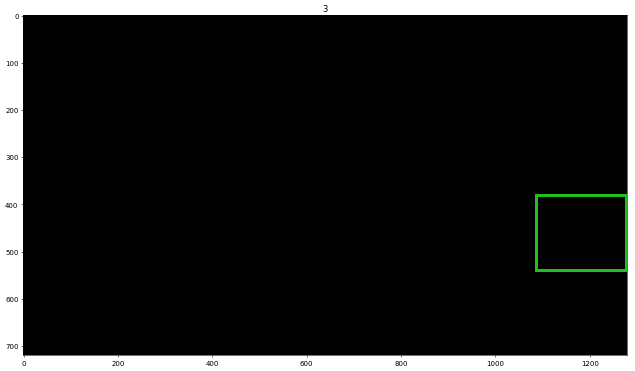

10.0012355481


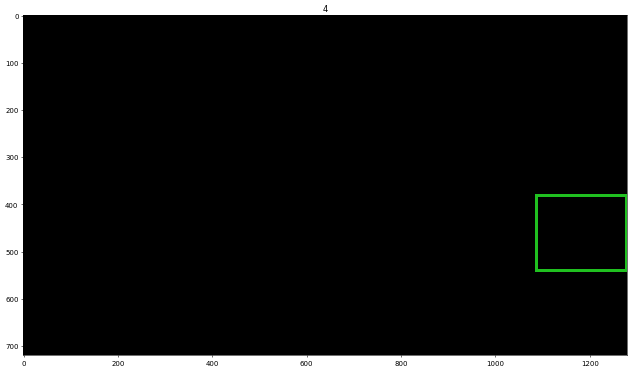

9.0011119933


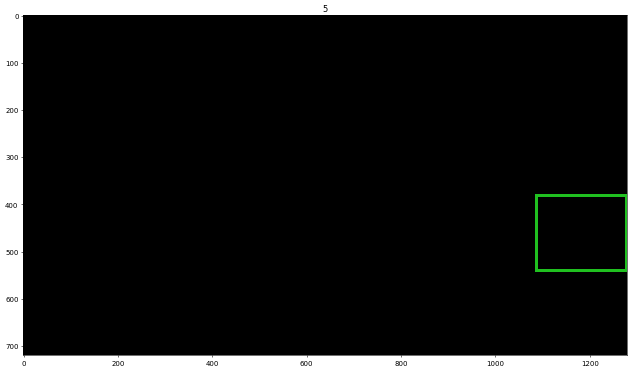

8.10100079397


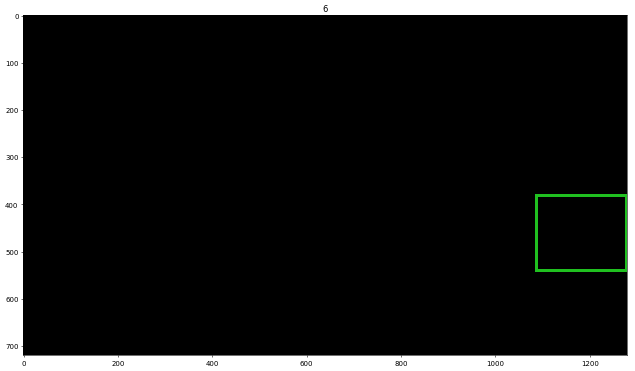

7.29090071457


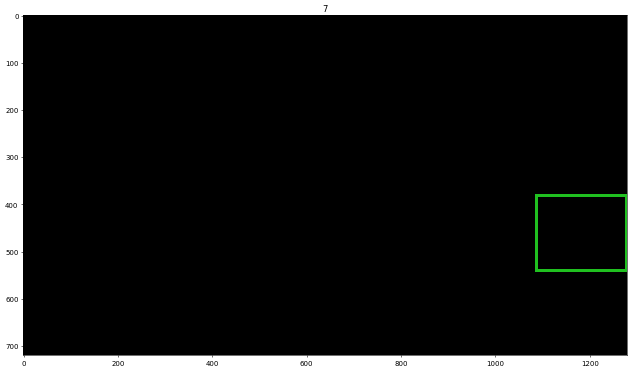

6.56181064311


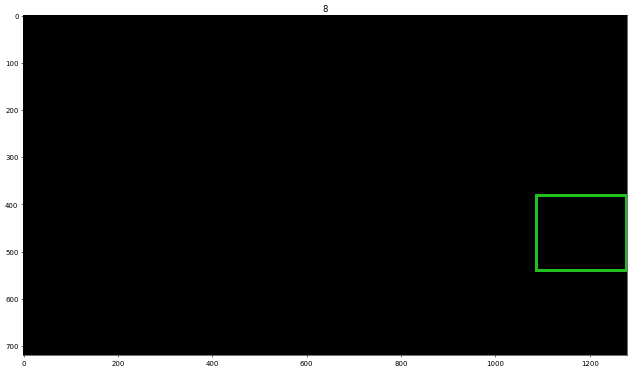

5.9056295788


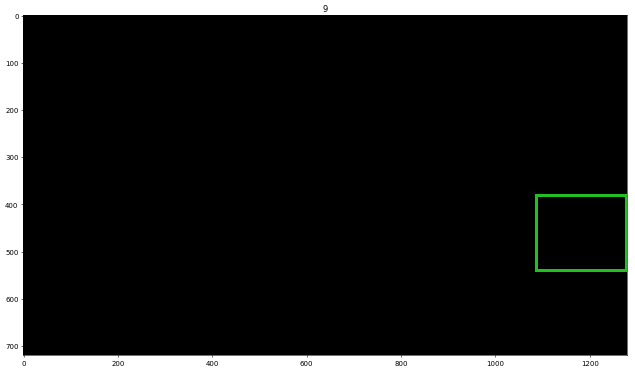

5.31506662092


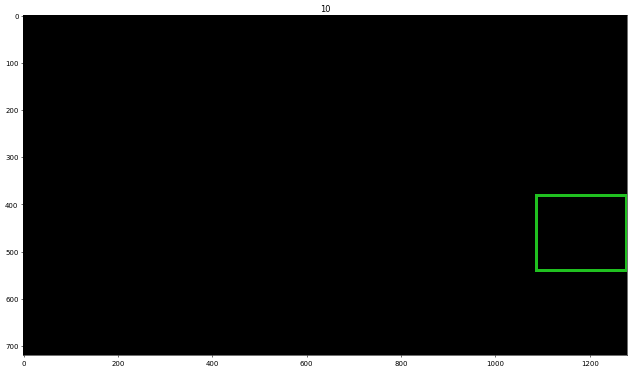

4.78355995883


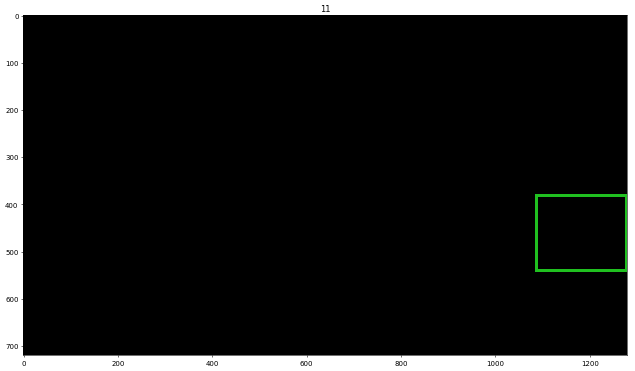

4.30520396295


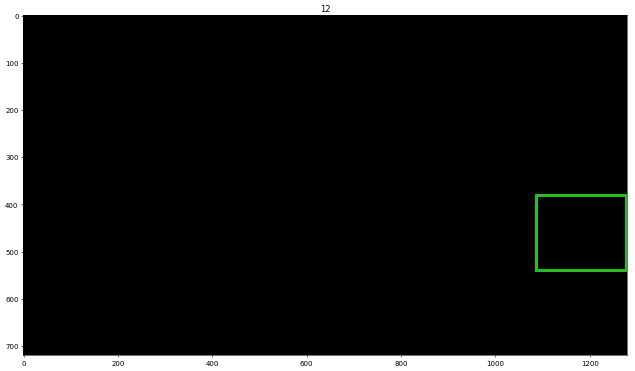

3.87468356665


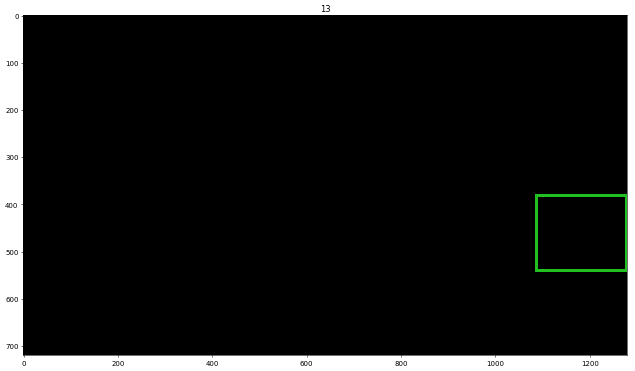

3.48721520999


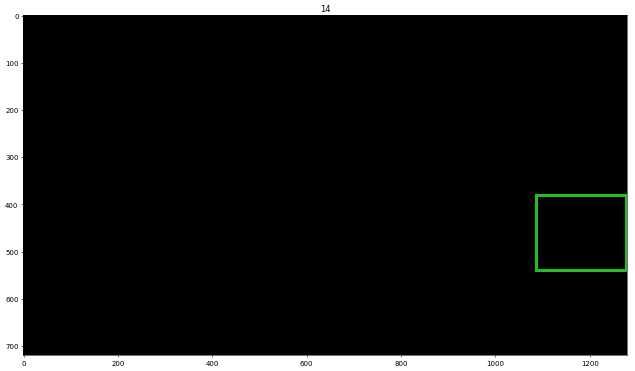

KeyboardInterrupt: 

In [26]:
#tracker.heatmap = None\
for i in range(25):
    frame = clip.get_frame(7 + i/clip.fps)
    plt.imshow(tracker(frame*0))
    plt.title(str(i))
    plt.show()

# %%prun -s tottime -l features|lesson|svm
idx = slice(1, 4, 4)
for path in sorted(glob.glob('test_images/*'))[:1]:
    plt.figure()
    image = cv2.imread(path)
    bboxes = tracking.find_cars(image,
                                yranges=[(350, 680), (350, 680), (350, 680), (350, 680)][idx],
                                scales=[0.5, 1, 1.5, 2][idx],
                                hog_cells_per_step=4,
                                extract_features=feature_extractor.extract_features,
                                predict=classifier.predict,
                               )
    merged_boxes = tracking.merge_boxes(image, bboxes, heat_threshold=1, expand_maximum=True)[0]
    result = tracking.draw_boxes(image, bboxes,
                                 colors=[(192,  32,  32), ( 32, 192,  32),
                                         ( 32,  32, 192), ( 64, 224, 192)][idx])
    plt.subplot(121)
    plt.imshow(result[..., ::-1])
    plt.title(path)
    plt.subplot(122)
    plt.imshow(tracking.draw_boxes(image, merged_boxes)[..., ::-1])
    plt.tight_layout()
    plt.show()